In [1]:
! pip install flaml[automl] matplotlib openml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.2/314.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 4.3 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=3c3456f858ac7f280dbd9e3b099543484773fe18ba7756c3070de4f5277e0ac6
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


Insights dataset saved to /kaggle/working/regional_insights.csv

Regional Connectivity Insights:
                              Region  Connectivity_Rate  Population_Served  \
0                            algeria           1.000000               5353   
1                             angola           0.000000              37236   
2                         antarctica           0.133333             329627   
3                       arctic ocean           0.000000              19525   
4                          argentina           0.166667              77116   
5                     atlantic ocean           0.375000             196220   
6                          australia           0.333333              61108   
7                            austria           0.000000               9371   
8                            bolivia           1.000000              17399   
9                             brazil           0.400000              41085   
10                            canada         

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


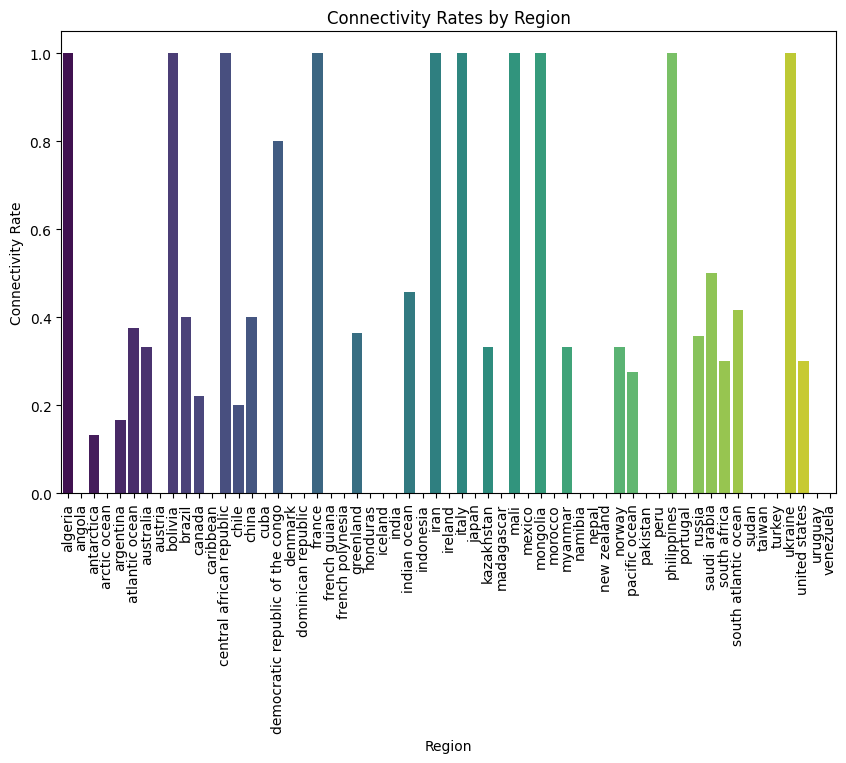


Node-Level Connectivity Insights:
                              Region  Connected_Node_Count  \
0                            algeria                     1   
1                         antarctica                     4   
2                          argentina                     1   
3                     atlantic ocean                     6   
4                          australia                     2   
5                            bolivia                     1   
6                             brazil                     2   
7                             canada                     2   
8           central african republic                     1   
9                              chile                     1   
10                             china                     2   
11  democratic republic of the congo                     4   
12                            france                     1   
13                         greenland                     4   
14                      indian ocea

In [2]:
import os
import numpy as np
import pandas as pd
from flaml import AutoML
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load and Preprocess the Data

def load_and_preprocess_data(nodes_filepath):
    """
    Load and preprocess the nodes dataset.
    """
    # Load the dataset
    nodes = pd.read_csv(nodes_filepath)
    
    # Ensure 'Node_ID' is treated as a string
    nodes['Node_ID'] = nodes['Node_ID'].astype(str)
    
    # Drop unnecessary columns (keep 'Node_ID')
    nodes.drop(columns=['Latitude', 'Longitude'], inplace=True)
    
    # Convert categorical columns to lowercase for consistency
    categorical_columns = ['Type', 'Region', 'Connectivity_Status', 'Existing_Infrastructure']
    for col in categorical_columns:
        nodes[col] = nodes[col].str.lower()
    
    # Encode the target column 'Connectivity_Status' into numeric labels
    label_encoder = LabelEncoder()
    nodes['Connectivity_Status'] = label_encoder.fit_transform(nodes['Connectivity_Status'])
    
    # One-hot encode the categorical columns: 'Type', 'Region', 'Existing_Infrastructure'
    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_features = onehot_encoder.fit_transform(nodes[['Type', 'Region', 'Existing_Infrastructure']])
    encoded_features_df = pd.DataFrame(encoded_features, columns=onehot_encoder.get_feature_names_out(['Type', 'Region', 'Existing_Infrastructure']))
    
    # Combine encoded features with the rest of the dataset
    nodes_encoded = pd.concat([nodes.drop(columns=['Type', 'Region', 'Existing_Infrastructure']), encoded_features_df], axis=1)
    
    # Split into features (X) and target (y)
    X = nodes_encoded.drop(columns=['Connectivity_Status'])
    y = nodes_encoded['Connectivity_Status']
    
    return X, y, label_encoder, onehot_encoder, nodes  # Return the original nodes DataFrame for analysis

# Step 2: Create Insights Dataset and Save as CSV

def create_insights_dataset(nodes):
    """
    Create insights dataset and save it as a CSV file.
    """
    # Convert 'Existing_Infrastructure' to numeric (1 for 'yes', 0 for 'no')
    nodes['Existing_Infrastructure'] = nodes['Existing_Infrastructure'].map({'yes': 1, 'no': 0})
    
    # Group by region and calculate key metrics
    regional_analysis = nodes.groupby('Region').agg({
        'Connectivity_Status': 'mean',  # Average connectivity status (1 = connected, 0 = unconnected)
        'Population_Served': 'sum',     # Total population served
        'Existing_Infrastructure': 'mean',  # Average existing infrastructure (1 = yes, 0 = no)
        'Node_ID': 'count',  # Number of nodes in each region
    }).reset_index()
    
    # Calculate the number of connected nodes in each region
    connected_nodes = nodes[nodes['Connectivity_Status'] == 1]  # Filter connected nodes
    connected_nodes_by_region = connected_nodes.groupby('Region')['Node_ID'].count().reset_index()
    connected_nodes_by_region.rename(columns={'Node_ID': 'Connected_Node_Count'}, inplace=True)
    
    # Merge connected node count into regional_analysis
    regional_analysis = pd.merge(regional_analysis, connected_nodes_by_region, on='Region', how='left')
    
    # Rename columns for clarity
    regional_analysis.rename(columns={
        'Connectivity_Status': 'Connectivity_Rate',
        'Existing_Infrastructure': 'Infrastructure_Rate',
        'Node_ID': 'Node_Count'
    }, inplace=True)
    
    # Save the insights dataset to a CSV file
    insights_filepath = '/kaggle/working/regional_insights.csv'
    regional_analysis.to_csv(insights_filepath, index=False)
    print(f"Insights dataset saved to {insights_filepath}")
    
    return regional_analysis

# Step 3: Analyze Data and Generate Connectivity Rates Graph

def analyze_data_and_generate_graph(nodes):
    """
    Analyze data and generate the Connectivity Rates by Region graph.
    """
    # Convert 'Existing_Infrastructure' to numeric (1 for 'yes', 0 for 'no')
    nodes['Existing_Infrastructure'] = nodes['Existing_Infrastructure'].map({'yes': 1, 'no': 0})
    
    # Group by region and calculate key metrics
    regional_analysis = nodes.groupby('Region').agg({
        'Connectivity_Status': 'mean',  # Average connectivity status (1 = connected, 0 = unconnected)
        'Population_Served': 'sum',     # Total population served
        'Existing_Infrastructure': 'mean',  # Average existing infrastructure (1 = yes, 0 = no)
        'Node_ID': 'count'  # Number of nodes in each region
    }).reset_index()
    
    # Rename columns for clarity
    regional_analysis.rename(columns={
        'Connectivity_Status': 'Connectivity_Rate',
        'Existing_Infrastructure': 'Infrastructure_Rate',
        'Node_ID': 'Node_Count'
    }, inplace=True)
    
    # Print regional insights
    print("\nRegional Connectivity Insights:")
    print(regional_analysis[['Region', 'Connectivity_Rate', 'Population_Served', 'Infrastructure_Rate']])
    
    # Identify regions with the lowest connectivity rates
    low_connectivity_regions = regional_analysis[regional_analysis['Connectivity_Rate'] < 0.5]
    if not low_connectivity_regions.empty:
        print("\nRegions with the lowest connectivity rates (priority for improvement):")
        print(low_connectivity_regions[['Region', 'Connectivity_Rate', 'Population_Served']])
    else:
        print("\nAll regions have relatively good connectivity rates.")
    
    # Visualize connectivity rates by region
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Region', y='Connectivity_Rate', data=regional_analysis, palette='viridis')
    plt.title('Connectivity Rates by Region')
    plt.xlabel('Region')
    plt.ylabel('Connectivity Rate')
    plt.xticks(rotation=90)
    plt.show()

    # Node-level connectivity insights
    print("\nNode-Level Connectivity Insights:")
    connected_nodes = nodes[nodes['Connectivity_Status'] == 1]  # Filter connected nodes
    connected_nodes_by_region = connected_nodes.groupby('Region').agg({
        'Node_ID': ['count', list]  # Count and list of connected nodes
    }).reset_index()
    
    # Flatten the multi-level column index
    connected_nodes_by_region.columns = ['Region', 'Connected_Node_Count', 'Connected_Node_IDs']
    
    print(connected_nodes_by_region)

# Step 4: Train the AutoML Model Using regional_insights.csv

def train_automl_model(insights_filepath):
    """
    Train an AutoML model using the regional_insights.csv file.
    """
    # Load the insights dataset
    regional_insights = pd.read_csv(insights_filepath)
    
    # Split the data into training and testing sets
    X = regional_insights.drop(columns=['Connectivity_Rate'])
    y = regional_insights['Connectivity_Rate']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize AutoML
    automl = AutoML()
    
    # Specify AutoML settings
    automl_settings = {
        "time_budget": 3600,  # 1 hour
        "metric": "rmse",   # Use RMSE for regression
        "task": "regression",
        "log_file_name": "connectivity_regression.log",
        "seed": 42,         # Set seed for reproducibility
    }
    
    # Train the model
    automl.fit(X_train=X_train, y_train=y_train, **automl_settings)
    
    # Evaluate the model on the test set
    y_pred = automl.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    
    print("\nModel Evaluation:")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    return automl

# Step 5: Save the Model and Encoders

def save_model_and_encoders(model, model_path):
    """
    Save the AutoML model.
    """
    joblib.dump(model, model_path)

# Step 6: Hardcoded User Input for Prediction

def get_hardcoded_user_input():
    """
    Return hardcoded user input for prediction.
    """
    user_input = {
        'Region': 'Russia',  # Example region
        'Type': 'School',   # Example organization type
        'Population_Served': 5000,  # Example population served
        'Existing_Infrastructure': 'Yes'  # Example infrastructure status
    }
    return user_input

# Step 7: Predict Connectivity Percentage Ratio

def predict_connectivity_percentage_ratio(input_data, model_path, X_columns):
    """
    Predict the connectivity percentage ratio based on user input.
    """
    # Load the saved model
    model = joblib.load(model_path)
    
    # Convert input data to a DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Ensure the input data has the same columns as the training data
    for col in X_columns:
        if col not in input_df.columns:
            input_df[col] = 0
    
    # Reorder columns to match the training data
    input_df = input_df[X_columns]
    
    # Predict the connectivity percentage ratio
    connectivity_percentage_ratio = model.predict(input_df)[0]
    
    return connectivity_percentage_ratio, input_data['Region'], input_data['Type'], input_data['Population_Served']

# Step 8: Run the Analysis and Prediction

if __name__ == "__main__":
    # Load and preprocess data
    X, y, label_encoder, onehot_encoder, nodes = load_and_preprocess_data(
        "/kaggle/input/public-sector-network/nodes.csv"
    )
    
    # Create insights dataset and save as CSV
    regional_analysis = create_insights_dataset(nodes)
    
    # Analyze data and generate the Connectivity Rates by Region graph
    analyze_data_and_generate_graph(nodes)
    
    # Train the AutoML model using the regional_insights.csv file
    insights_filepath = '/kaggle/working/regional_insights.csv'
    automl_model = train_automl_model(insights_filepath)
    
    # Save the model
    model_path = '/kaggle/working/connectivity_regression_model.pkl'
    save_model_and_encoders(automl_model, model_path)
    
    # Get hardcoded user input
    user_input = get_hardcoded_user_input()
    
    # Predict connectivity percentage ratio
    connectivity_percentage_ratio, region, org_type, population_served = predict_connectivity_percentage_ratio(
        user_input,
        model_path,
        regional_analysis.drop(columns=['Connectivity_Rate']).columns
    )
    
    # Display the results
    print("\nPrediction Results:")
    print(f"Region: {region}")
    print(f"Organization Type: {org_type}")
    print(f"Population Served: {population_served}")
    print(f"Predicted Connectivity Percentage Ratio: {connectivity_percentage_ratio:.2f}%")